# Zipline algorithm analysis example in pyfolio

Here's an example where we run an algorithm with zipline, then produce tear sheets for that algorithm.

## Imports
Import pyfolio, along with the necessary modules for running our zipline backtest.

In [1]:
%matplotlib inline
import pyfolio as pf

/home/wiecki/miniconda3/lib/python3.4/site-packages/pandas/io/data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [2]:
import numpy as np
import pandas as pd

import sys
import logbook
import numpy as np
from datetime import datetime
import pytz

# Import Zipline, the open source backtester
from zipline import TradingAlgorithm
from zipline.data.loader import load_bars_from_yahoo
from zipline.api import order_target, symbol, history, add_history, schedule_function, date_rules, time_rules
from zipline.algorithm import TradingAlgorithm
from zipline.utils.factory import load_from_yahoo
from zipline.finance import commission

## Run our zipline algorithm
This algorithm can also be adjusted to execute a modified, or completely different, trading strategy.

In [3]:
# Zipline trading algorithm
# Taken from zipline.examples.olmar
zipline_logging = logbook.NestedSetup([
    logbook.NullHandler(level=logbook.DEBUG),
    logbook.StreamHandler(sys.stdout, level=logbook.INFO),
    logbook.StreamHandler(sys.stderr, level=logbook.ERROR),
])
zipline_logging.push_application()

STOCKS = ['AMD', 'CERN', 'COST', 'DELL', 'GPS', 'INTC', 'MMM']


# On-Line Portfolio Moving Average Reversion

# More info can be found in the corresponding paper:
# http://icml.cc/2012/papers/168.pdf
def initialize(algo, eps=1, window_length=5):
    algo.stocks = STOCKS
    algo.sids = [algo.symbol(symbol) for symbol in algo.stocks]
    algo.m = len(algo.stocks)
    algo.price = {}
    algo.b_t = np.ones(algo.m) / algo.m
    algo.last_desired_port = np.ones(algo.m) / algo.m
    algo.eps = eps
    algo.init = True
    algo.days = 0
    algo.window_length = window_length
    algo.add_transform('mavg', 5)

    algo.set_commission(commission.PerShare(cost=0))


def handle_data(algo, data):
    algo.days += 1
    if algo.days < algo.window_length:
        return

    if algo.init:
        rebalance_portfolio(algo, data, algo.b_t)
        algo.init = False
        return

    m = algo.m

    x_tilde = np.zeros(m)
    b = np.zeros(m)

    # find relative moving average price for each asset
    for i, sid in enumerate(algo.sids):
        price = data[sid].price
        # Relative mean deviation
        x_tilde[i] = data[sid].mavg(algo.window_length) / price

    ###########################
    # Inside of OLMAR (algo 2)
    x_bar = x_tilde.mean()

    # market relative deviation
    mark_rel_dev = x_tilde - x_bar

    # Expected return with current portfolio
    exp_return = np.dot(algo.b_t, x_tilde)
    weight = algo.eps - exp_return
    variability = (np.linalg.norm(mark_rel_dev)) ** 2

    # test for divide-by-zero case
    if variability == 0.0:
        step_size = 0
    else:
        step_size = max(0, weight / variability)

    b = algo.b_t + step_size * mark_rel_dev
    b_norm = simplex_projection(b)
    np.testing.assert_almost_equal(b_norm.sum(), 1)

    rebalance_portfolio(algo, data, b_norm)

    # update portfolio
    algo.b_t = b_norm


def rebalance_portfolio(algo, data, desired_port):
    # rebalance portfolio
    desired_amount = np.zeros_like(desired_port)
    current_amount = np.zeros_like(desired_port)
    prices = np.zeros_like(desired_port)

    if algo.init:
        positions_value = algo.portfolio.starting_cash
    else:
        positions_value = algo.portfolio.positions_value + \
            algo.portfolio.cash

    for i, sid in enumerate(algo.sids):
        current_amount[i] = algo.portfolio.positions[sid].amount
        prices[i] = data[sid].price

    desired_amount = np.round(desired_port * positions_value / prices)

    algo.last_desired_port = desired_port
    diff_amount = desired_amount - current_amount

    for i, sid in enumerate(algo.sids):
        algo.order(sid, diff_amount[i])


def simplex_projection(v, b=1):
    """Projection vectors to the simplex domain

    Implemented according to the paper: Efficient projections onto the
    l1-ball for learning in high dimensions, John Duchi, et al. ICML 2008.
    Implementation Time: 2011 June 17 by Bin@libin AT pmail.ntu.edu.sg
    Optimization Problem: min_{w}\| w - v \|_{2}^{2}
    s.t. sum_{i=1}^{m}=z, w_{i}\geq 0

    Input: A vector v \in R^{m}, and a scalar z > 0 (default=1)
    Output: Projection vector w

    :Example:
    >>> proj = simplex_projection([.4 ,.3, -.4, .5])
    >>> print(proj)
    array([ 0.33333333, 0.23333333, 0. , 0.43333333])
    >>> print(proj.sum())
    1.0

    Original matlab implementation: John Duchi (jduchi@cs.berkeley.edu)
    Python-port: Copyright 2013 by Thomas Wiecki (thomas.wiecki@gmail.com).
    """

    v = np.asarray(v)
    p = len(v)

    # Sort v into u in descending order
    v = (v > 0) * v
    u = np.sort(v)[::-1]
    sv = np.cumsum(u)

    rho = np.where(u > (sv - b) / np.arange(1, p + 1))[0][-1]
    theta = np.max([0, (sv[rho] - b) / (rho + 1)])
    w = (v - theta)
    w[w < 0] = 0
    return w

start = datetime(2004, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2010, 1, 1, 0, 0, 0, 0, pytz.utc)
data = load_from_yahoo(stocks=STOCKS, indexes={}, start=start, end=end)
data = data.dropna()
olmar = TradingAlgorithm(handle_data=handle_data,
                         initialize=initialize,
                         identifiers=STOCKS)
backtest = olmar.run(data)

AMD
CERN
COST
DELL
GPS
INTC
MMM
[2015-10-21 14:10:42.252494] INFO: Performance: Simulated 1511 trading days out of 1511.
[2015-10-21 14:10:42.253271] INFO: Performance: first open: 2004-01-02 14:31:00+00:00
[2015-10-21 14:10:42.253904] INFO: Performance: last close: 2009-12-31 21:00:00+00:00


## Extract metrics
Get the returns, positions, and transactions from the zipline backtest object.

In [4]:
returns, positions, transactions, gross_lev = pf.utils.extract_rets_pos_txn_from_zipline(backtest)

## Single plot example
Make one plot of the top 5 drawdown periods.

/home/wiecki/miniconda3/lib/python3.4/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The "loc" positional argument to legend is deprecated. Please use the "loc" keyword instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


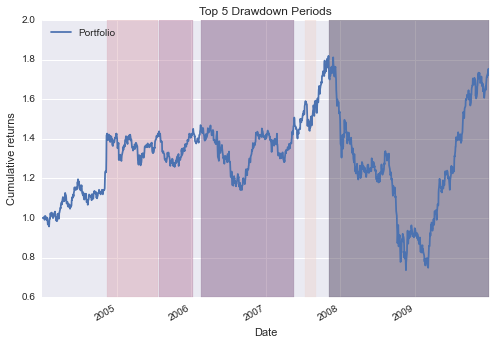

In [5]:
pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')

## Full tear sheet example
Create a full tear sheet for our algorithm. As an example, set the live start date to something arbitrary.

Entire data start date: 2004-01-02
Entire data end date: 2009-12-31


Out-of-Sample Months: 2
Backtest Months: 69
                   Backtest  Out_of_Sample  All_History
annual_return          0.12           0.06         0.12
annual_volatility      0.26           0.22         0.25
sharpe_ratio           0.47           0.28         0.48
calmar_ratio           0.20           0.84         0.21
stability              0.00           0.05         0.01
max_drawdown          -0.60          -0.07        -0.60
omega_ratio            1.09           1.05         1.09
sortino_ratio          0.70           0.39         0.71
skewness               0.28          -0.28         0.27
kurtosis               4.10           0.46         4.05
alpha                  0.09          -0.11         0.09
beta                   0.81           1.18         0.81

Worst Drawdown Periods
   net drawdown in %  peak date valley date recovery date duration
0              59.50 2007-11-06  2008-11-20           NaT      NaN


/home/wiecki/miniconda3/lib/python3.4/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The "loc" positional argument to legend is deprecated. Please use the "loc" keyword instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


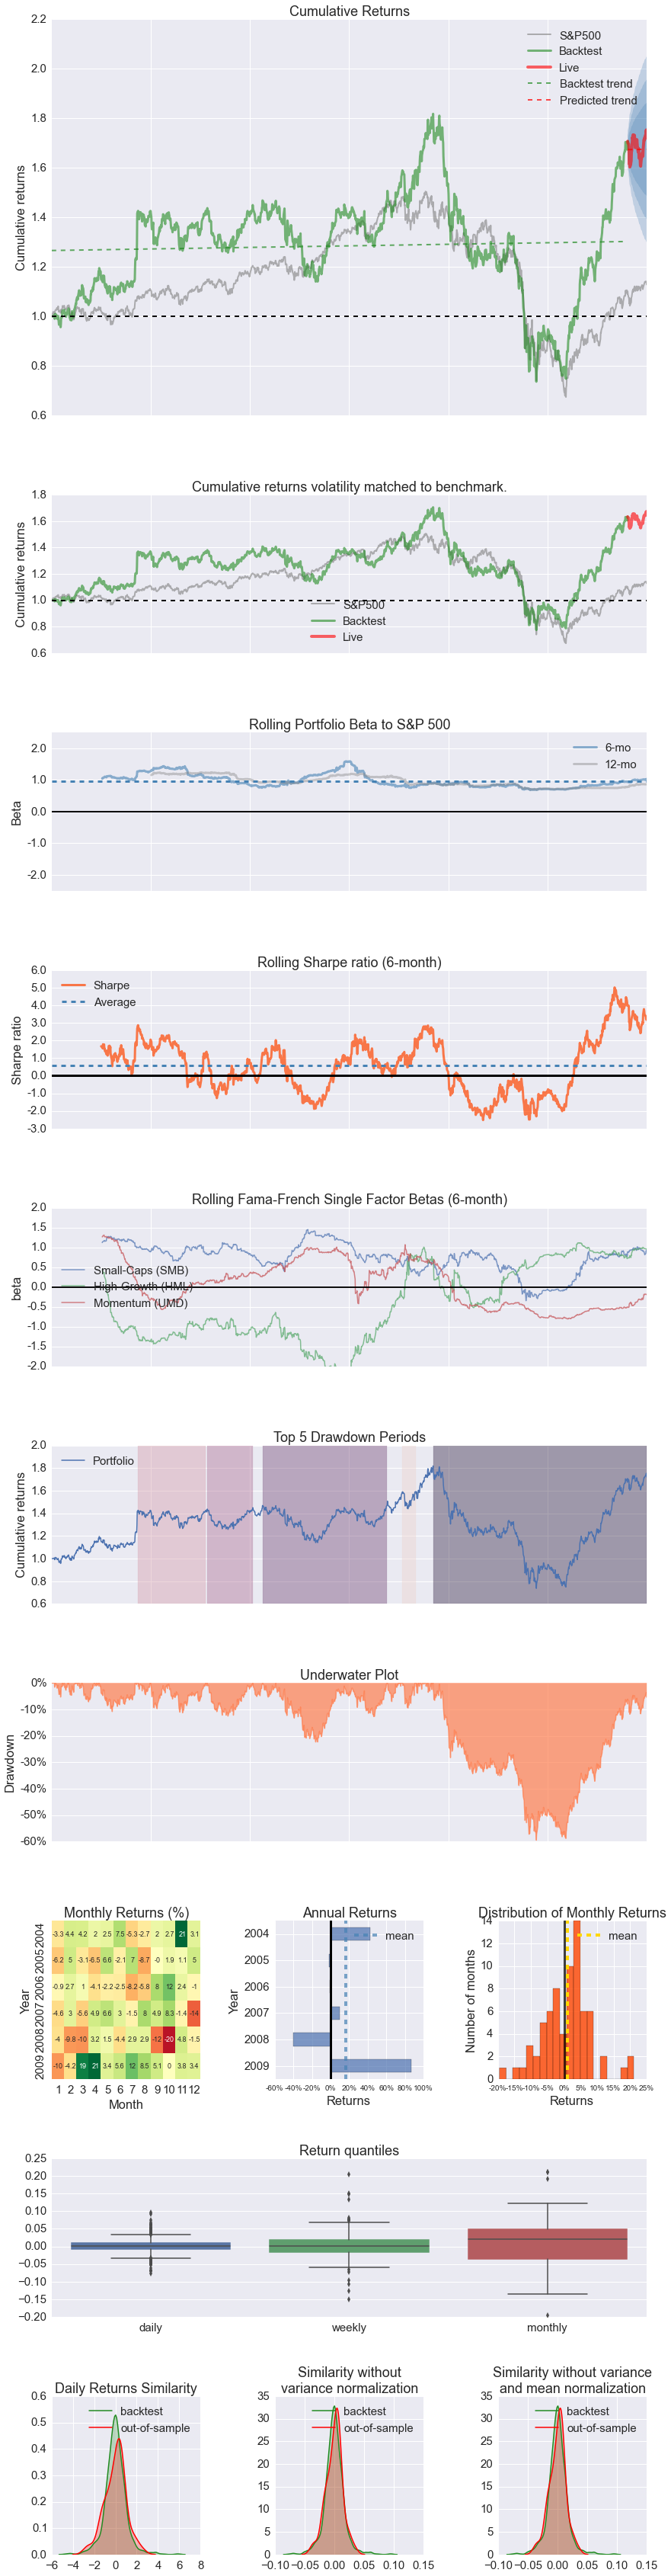


Stress Events
          mean    min    max
Lehmann -0.003 -0.044  0.044
Aug07    0.003 -0.030  0.030
Sept08  -0.006 -0.043  0.040
2009Q1  -0.004 -0.050  0.034
2009Q2   0.007 -0.038  0.062


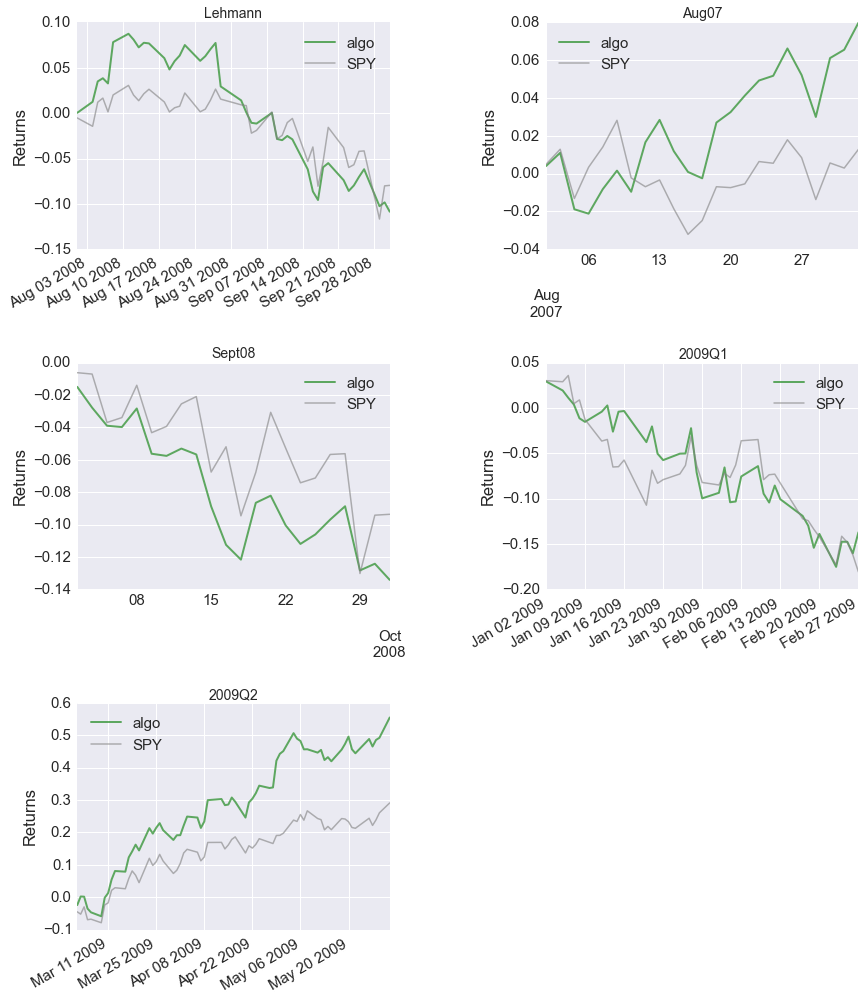



Top 10 long positions of all time (and max%)
[2 6 1 3 0 5 4]
[ 0.993  0.911  0.845  0.717  0.709  0.666  0.62 ]


Top 10 short positions of all time (and max%)
[]
[]


Top 10 positions of all time (and max%)
[2 6 1 3 0 5 4]
[ 0.993  0.911  0.845  0.717  0.709  0.666  0.62 ]


All positions ever held
[2 6 1 3 0 5 4]
[ 0.993  0.911  0.845  0.717  0.709  0.666  0.62 ]




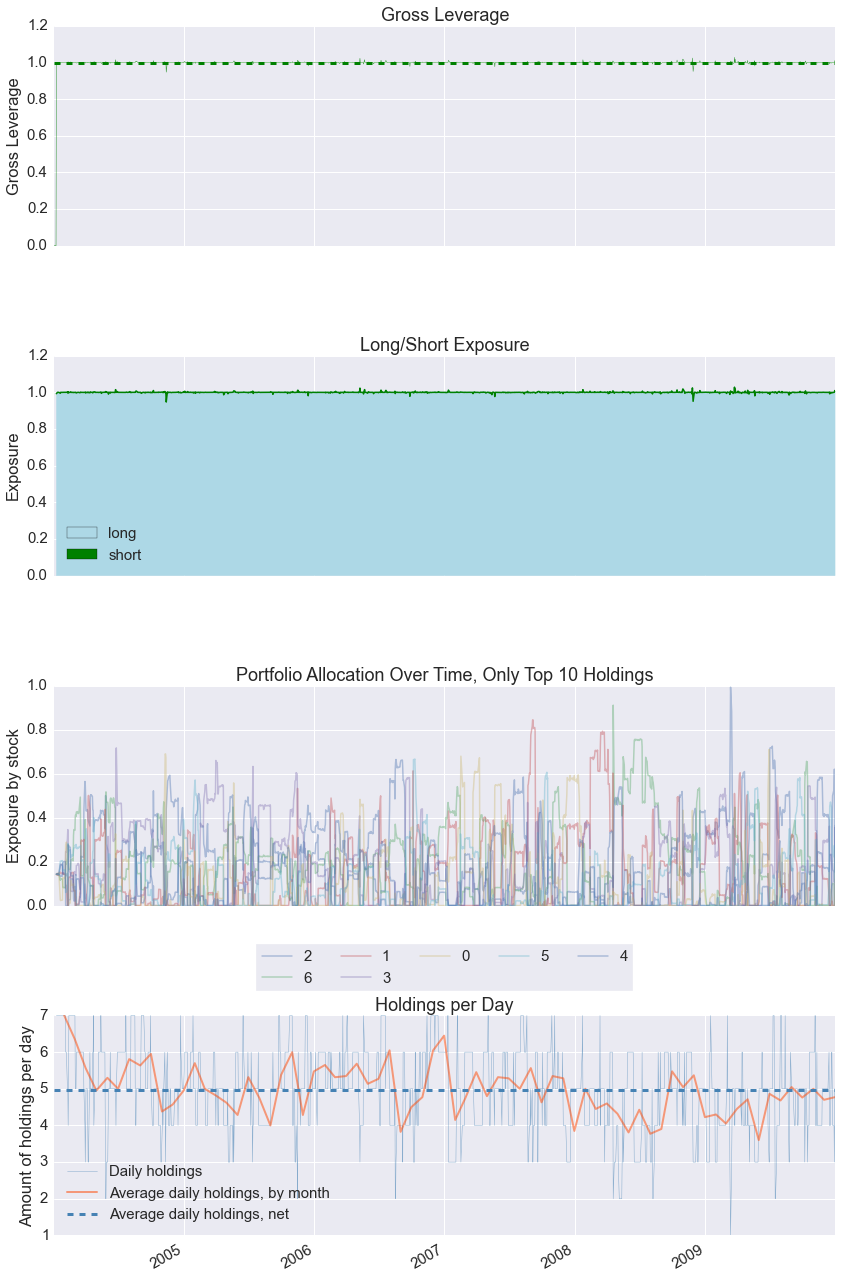

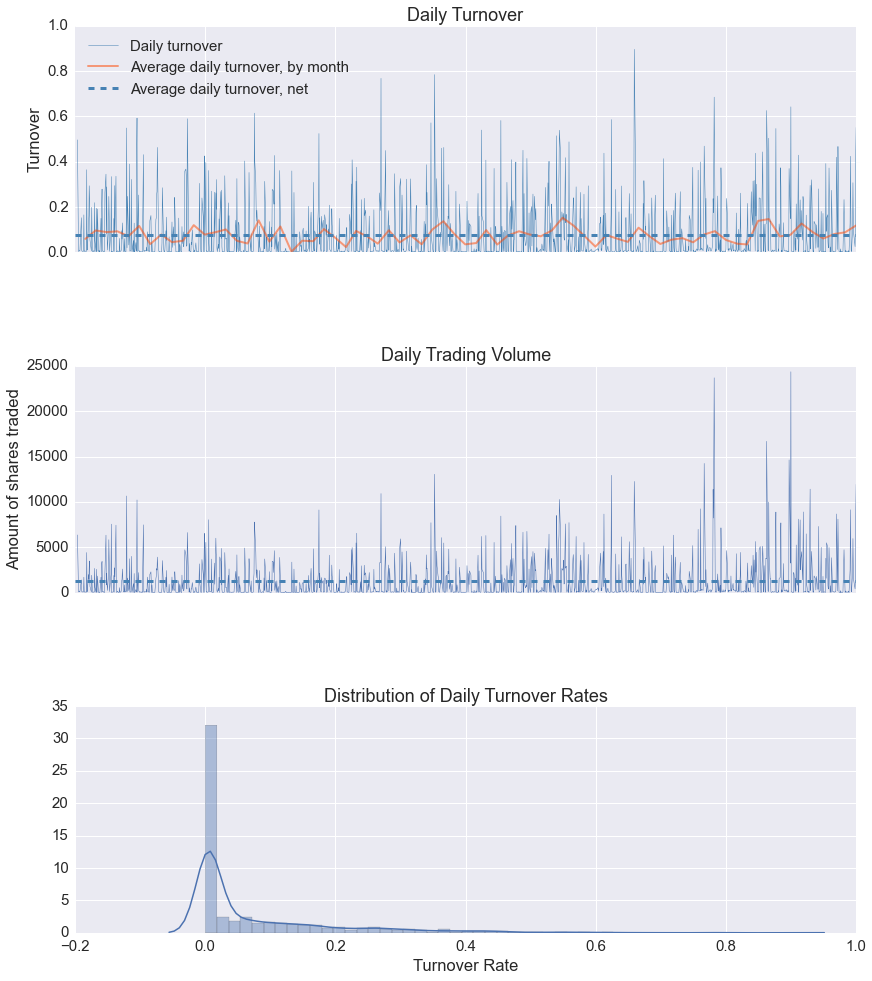

In [6]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions,
                          gross_lev=gross_lev, live_start_date='2009-10-22')

## Suppressing symbol output

When sharing tear sheets it might be undesirable to display which symbols where used by a strategy. To suppress these in the tear sheet you can pass `hide_positions=True`.

Entire data start date: 2004-01-02
Entire data end date: 2009-12-31


Out-of-Sample Months: 2
Backtest Months: 69
                   Backtest  Out_of_Sample  All_History
annual_return          0.12           0.06         0.12
annual_volatility      0.26           0.22         0.25
sharpe_ratio           0.47           0.28         0.48
calmar_ratio           0.20           0.84         0.21
stability              0.00           0.05         0.01
max_drawdown          -0.60          -0.07        -0.60
omega_ratio            1.09           1.05         1.09
sortino_ratio          0.70           0.39         0.71
skewness               0.28          -0.28         0.27
kurtosis               4.10           0.46         4.05
alpha                  0.09          -0.11         0.09
beta                   0.81           1.18         0.81

Worst Drawdown Periods
   net drawdown in %  peak date valley date recovery date duration
0              59.50 2007-11-06  2008-11-20           NaT      NaN


/home/wiecki/miniconda3/lib/python3.4/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The "loc" positional argument to legend is deprecated. Please use the "loc" keyword instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


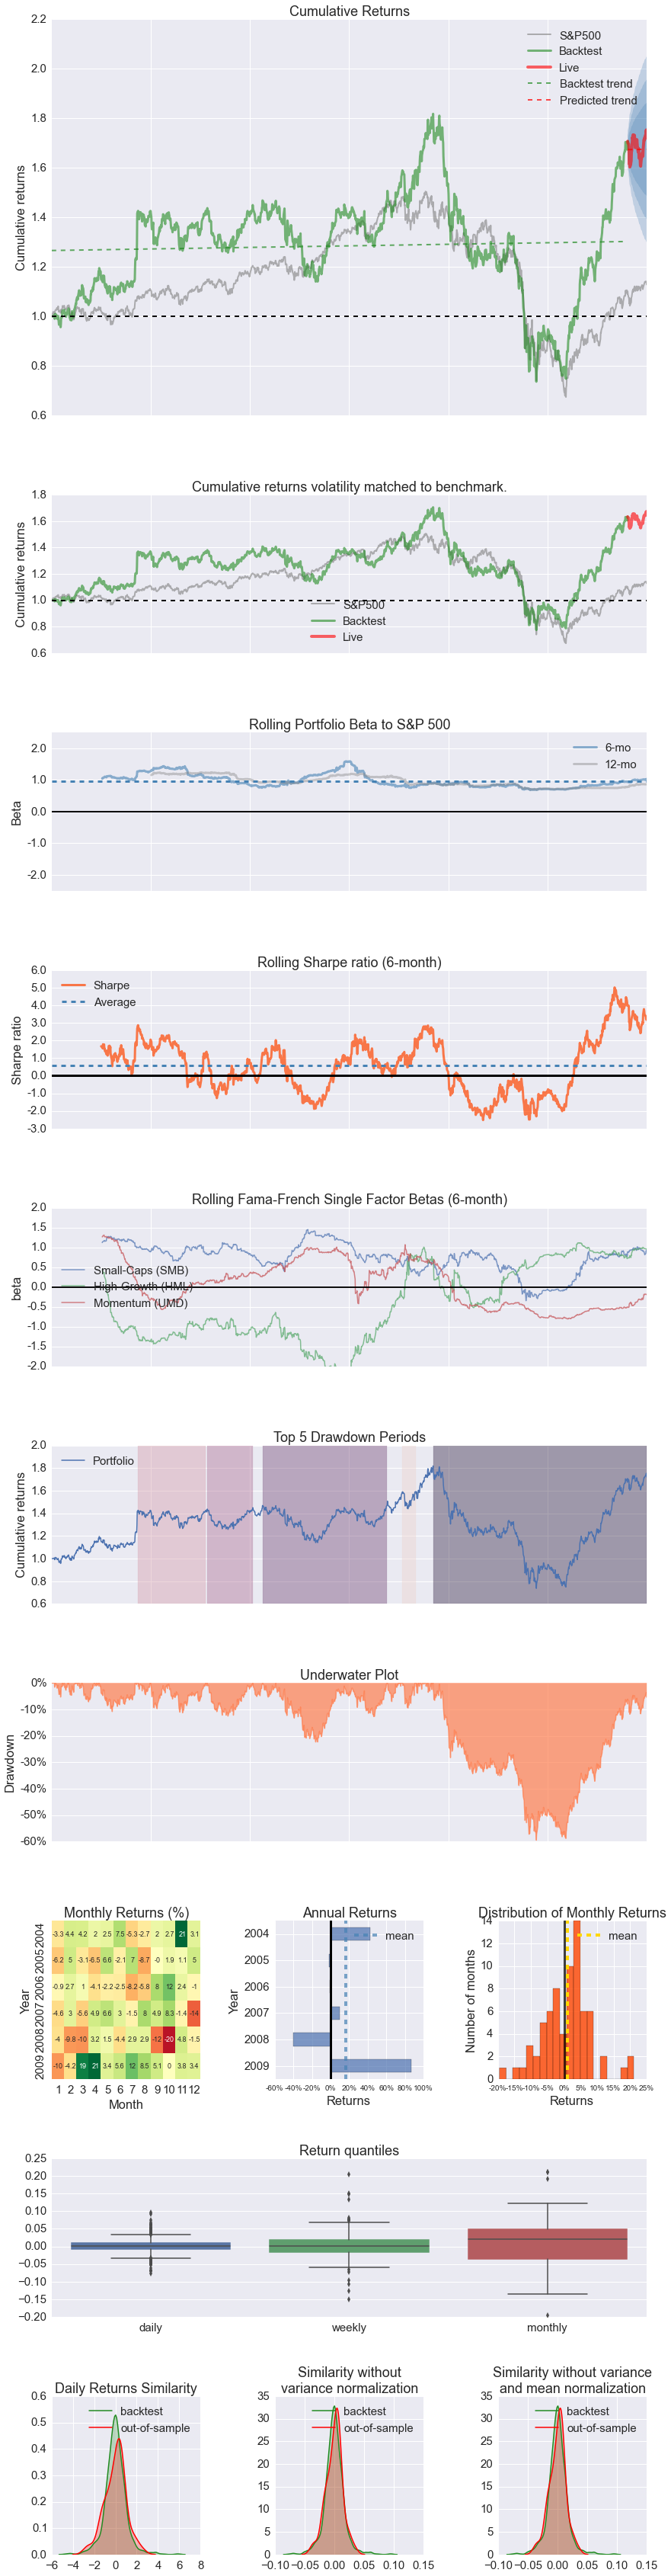


Stress Events
          mean    min    max
Lehmann -0.003 -0.044  0.044
Aug07    0.003 -0.030  0.030
Sept08  -0.006 -0.043  0.040
2009Q1  -0.004 -0.050  0.034
2009Q2   0.007 -0.038  0.062


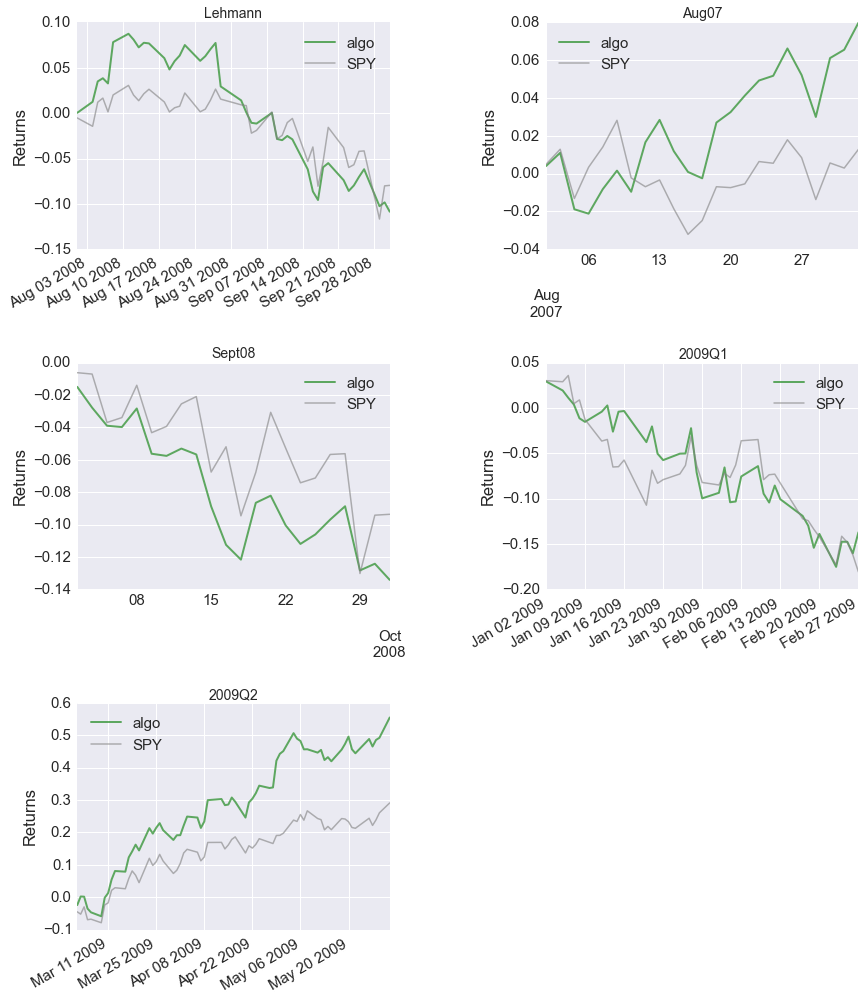

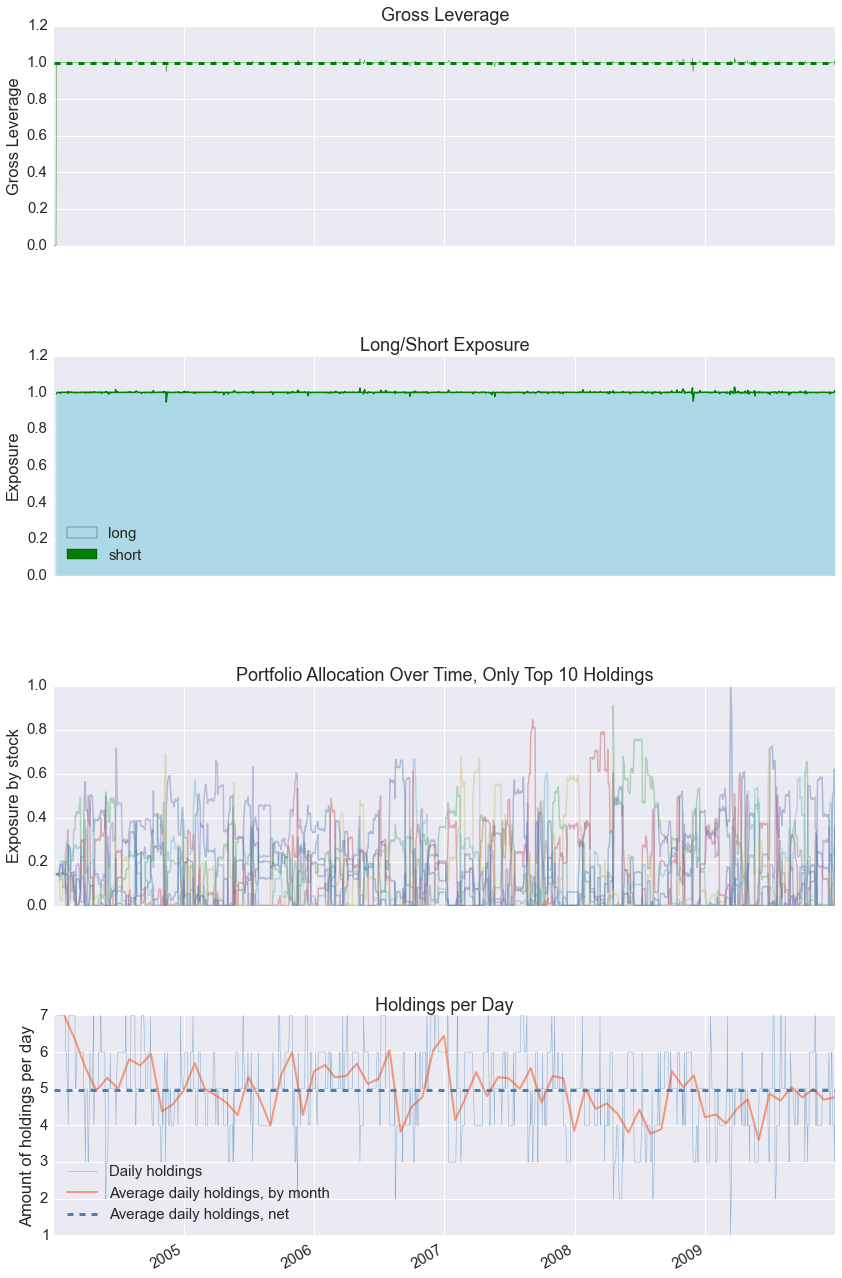

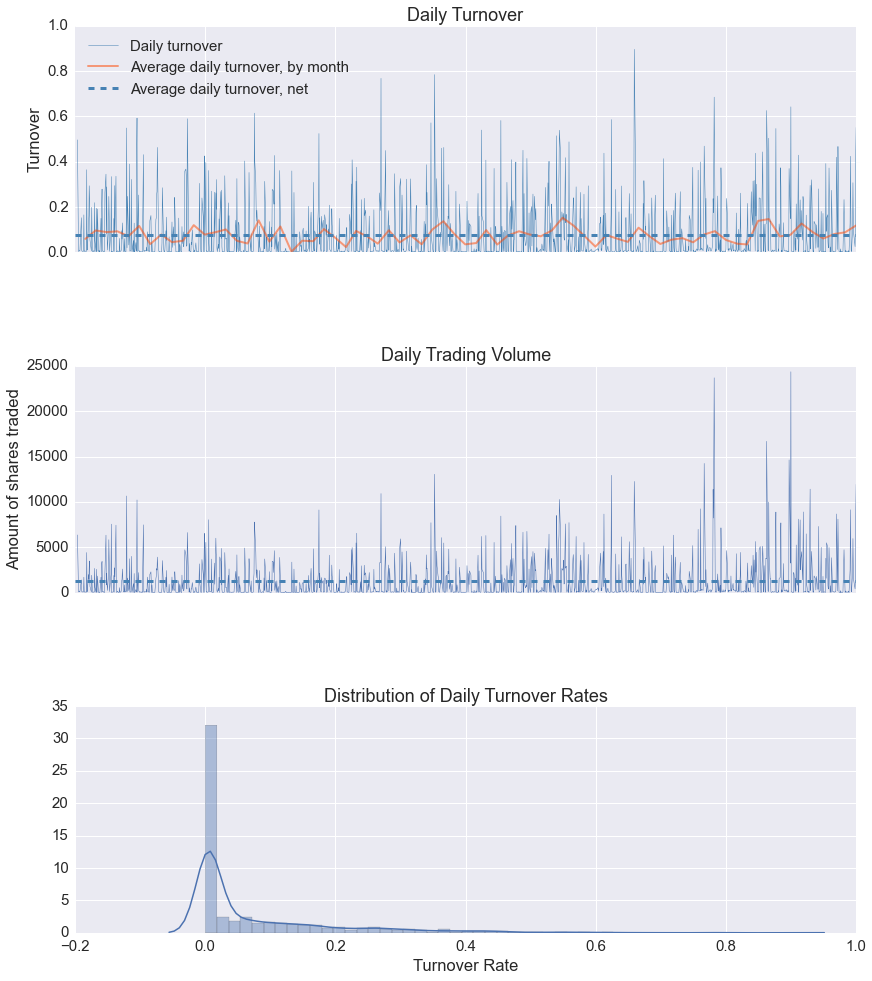

In [7]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions,
                          gross_lev=gross_lev, live_start_date='2009-10-22',
                          hide_positions=True)